In [364]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import export_graphviz
import graphviz
import ast
import warnings
warnings.filterwarnings('ignore')

In [356]:
behavior = pd.read_csv('./data/behavior_reduced.csv', delimiter=',', index_col=False)

In [357]:
len(behavior)

689

In [358]:
behavior.drop(columns=['pid', 'engagement_score', 'norm_engagement_score'], inplace=True)

In [359]:
behavior['code'] = behavior['code'].apply(lambda x: ast.literal_eval(x))

In [360]:
behavior = behavior[~behavior['code'].apply(lambda x: x[0] in ['Avoid', 'Follow', 'Pass'])]

In [361]:
len(behavior)

658

In [281]:
def code_one_hot_encoding(df):
    # 행동 코드 리스트
    actions = ['Approach', 'None', 'Touch', 'Gesture']

    # 각각의 sublist를 one-hot encoding하여 다차원 리스트로 생성
    one_hot_data = []
    for sublist in df['code']:
        one_hot_sublist = np.zeros((len(sublist), len(actions)))
        for i, code in enumerate(sublist):
            index = actions.index(code)
            one_hot_sublist[i][index] = 1
        one_hot_data.append(one_hot_sublist)
    
    df['encoded_code'] = one_hot_data
    df['encoded_code'] = df[['encoded_code']].apply(lambda x: [np.array(item).astype(int) for item in x])

    return df

In [282]:
def code_one_hot_decimal_encoding(df):
    actions = ['Approach', 'None', 'Touch', 'Gesture']
    encoded_data = []

    for sequence in df['code']:
        encoded_sequence = []
        for action in sequence:
            one_hot = [int(action == a) for a in actions]
            decimal = int(''.join(map(str, one_hot)), 2)
            encoded_sequence.append(decimal)
        encoded_data.append(encoded_sequence)

    df['encoded_code'] = encoded_data
    
    return df

In [315]:
def padding_encoding_data(df, col_name):
    max_length = max(map(len, df[col_name]))  # 가장 긴 sequence의 길이 구하기

    padded_encoded_code = []
    for encoded_code in df[col_name]:
        # 가장 긴 sequence 길이를 기준으로 padding 적용
        padded_encoded_code.append(encoded_code + [0] * (max_length - len(encoded_code)))
    
#     # 모든 리스트를 동일한 길이의 1D 배열로 변환
#     padded_encoded_code_np = np.array([np.array(x) for x in padded_encoded_code])

#     # 2D Numpy 배열 생성
#     padded_encoded_code_np_2d = np.vstack(padded_encoded_code_np)
    
    df[col_name] = padded_encoded_code
    df[col_name] = df[col_name].apply(lambda x: ''.join(str(i) for i in x))

    return df

In [316]:
behavior = code_one_hot_decimal_encoding(behavior)
behavior = padding_encoding_data(behavior, "encoded_code")

In [284]:
behavior['encoded_code'] = behavior['encoded_code'].tolist()

In [292]:
# behavior['duration'] = behavior['duration'].apply(lambda x: ast.literal_eval(x))
behavior['duration_sum'] = behavior['duration'].apply(lambda x: sum(x))

In [317]:
behavior

,code,code_count,code_score,duration,time_ratio,A/C,M/F,appearance,engagement_level,encoded_code,duration_sum
0,"[Approach, None]",2,"[3, 4]","[2720, 2960]","[0.4788732394366197, 0.5211267605633803]",Child,Female,"포니테일, 아이보리색 점퍼, 검정색 바지",low,8400000000000000000000,5680
1,"[Approach, None]",2,"[3, 4]","[5520, 6320]","[0.46621621621621623, 0.5337837837837838]",Child,Female,"포니테일, 아이보리색 점퍼, 검정색 바지",low,8400000000000000000000,11840
2,"[Approach, None]",2,"[3, 4]","[9240, 15600]","[0.3719806763285024, 0.6280193236714976]",Child,Male,"검정색 점퍼, 청바지, 검정/흰색 운동화",low,8400000000000000000000,24840
3,"[Approach, None]",2,"[3, 4]","[5920, 6360]","[0.4820846905537459, 0.5179153094462541]",Child,Male,"검정색 점퍼, 청바지, 검정/흰색 운동화",low,8400000000000000000000,12280
4,"[Approach, None]",2,"[3, 4]","[4160, 7760]","[0.348993288590604, 0.6510067114093959]",Child,Male,"검정 마스크, 흰색 후리스, 회색 트레이닝 바지",low,8400000000000000000000,11920
...,...,...,...,...,...,...,...,...,...,...,...
684,"[Approach, None, Gesture, None]",4,"[3, 4, 5, 4]","[7680, 5200, 2800, 2400]","[0.4247787610619469, 0.28761061946902655, 0.15...",Child,Male,"검은색 롱패딩, 검은색 바지",low,8414000000000000000000,18080
685,"[Approach, None, Gesture, None, Gesture, None]",6,"[3, 4, 5, 4, 5, 4]","[5360, 45360, 1840, 36400, 6320, 62800]","[0.03390688259109312, 0.28694331983805665, 0.0...",Child,Male,"검은색 롱패딩, 검은색 바지",high,8414140000000000000000,158080
686,"[Approach, None]",2,"[3, 4]","[3840, 11680]","[0.24742268041237114, 0.7525773195876289]",Child,Male,"검은색 롱패딩, 검은색 바지",low,8400000000000000000000,15520
687,"[Approach, None]",2,"[3, 4]","[4800, 16480]","[0.22556390977443608, 0.7744360902255639]",Child,Male,"검은색 롱패딩, 검은색 바지",low,8400000000000000000000,21280


# Decision Tree

In [319]:
data = behavior[['encoded_code', 'duration_sum', 'code_count', 'engagement_level']]

# DecicionTreeClassifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)
# 학습/검증 데이터셋 나누기
X_train, X_test, y_train, y_test = train_test_split(data.drop('engagement_level', axis=1), data['engagement_level'], test_size=0.2, random_state=42, stratify=data['engagement_level'])

In [320]:
X_test

,encoded_code,duration_sum,code_count
549,8240000000000000000000,18640,3
154,8420000000000000000000,38800,3
681,8400000000000000000000,16960,2
273,8400000000000000000000,33520,2
275,8400000000000000000000,19360,2
...,...,...,...
383,8240000000000000000000,11280,3
331,8400000000000000000000,32080,2
446,8400000000000000000000,5760,2
83,8400000000000000000000,139440,2


In [321]:
# DecisionTreeClassifier 학습
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Decision Tree 예측 정확도 : {0:.4f}'.format(accuracy))
# DecisionTreeClassifier의 하이퍼 파리미터 추출
print('\nDecisionTreeClassifier 기본 하이퍼파라미터:\n', dt_clf.get_params())

Decision Tree 예측 정확도 : 0.8409

DecisionTreeClassifier 기본 하이퍼파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [322]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dt_clf, out_file="tree_reduced.dot", class_names = ['low', 'high'], 
                           feature_names = ['encoded_code', 'encoded_duration', 'code_count'], impurity=True, filled=True)

Feature Importances:
[0.245 0.316 0.439]

encoded_code: 0.245
encoded_duration: 0.316
code_count: 0.439


Text(0, 0.5, 'feature')

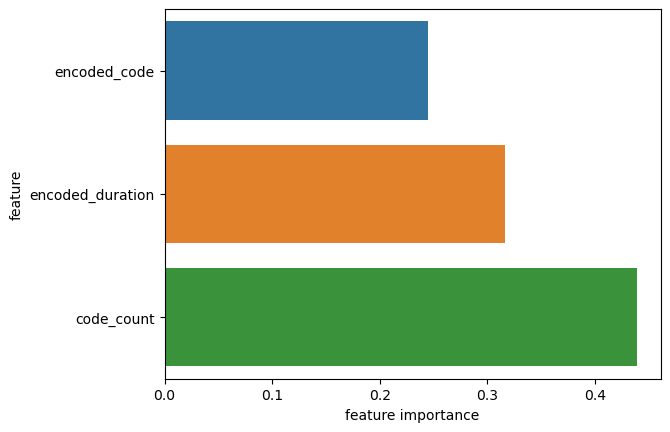

In [324]:
import seaborn as sns
%matplotlib inline

# feature importance 추출
print("Feature Importances:\n{0}\n".format(np.round(dt_clf.feature_importances_, 3)))

# feature 별 feature importance 매핑
for name, value in zip(['encoded_code', 'encoded_duration', 'code_count'], dt_clf.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))
    
# feature importance 시각화
g = sns.barplot(x=dt_clf.feature_importances_, y=['encoded_code', 'encoded_duration', 'code_count'])
g.set_xlabel('feature importance', size=10)
g.set_ylabel('feature', size=10)

In [325]:
data = behavior[['encoded_code', 'engagement_level']]

In [326]:
# DecicionTreeClassifier 생성
dt_clf = DecisionTreeClassifier(random_state=156)
# 학습/검증 데이터셋 나누기
X_train, X_test, y_train, y_test = train_test_split(data.drop('engagement_level', axis=1), data['engagement_level'], test_size=0.2, random_state=42, stratify=data['engagement_level'])

In [327]:
# DecisionTreeClassifier 학습
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Decision Tree 예측 정확도 : {0:.4f}'.format(accuracy))
# DecisionTreeClassifier의 하이퍼 파리미터 추출
print('\nDecisionTreeClassifier 기본 하이퍼파라미터:\n', dt_clf.get_params())

Decision Tree 예측 정확도 : 0.8636

DecisionTreeClassifier 기본 하이퍼파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [328]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dt_clf, out_file="tree_reduced2.dot", class_names = ['low', 'high'], 
                           feature_names = ['encoded_code'], impurity=True, filled=True)

Feature Importances:
[1.]

encoded_code: 1.000


Text(0, 0.5, 'feature')

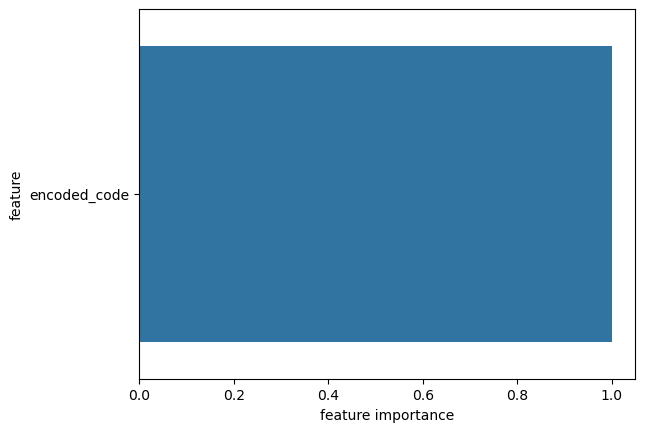

In [330]:
import seaborn as sns
%matplotlib inline

# feature importance 추출
print("Feature Importances:\n{0}\n".format(np.round(dt_clf.feature_importances_, 3)))

# feature 별 feature importance 매핑
for name, value in zip(['encoded_code'], dt_clf.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))
    
# feature importance 시각화
g = sns.barplot(x=dt_clf.feature_importances_, y=['encoded_code'])
g.set_xlabel('feature importance', size=10)
g.set_ylabel('feature', size=10)

In [366]:
data

,encoded_code,duration_sum,code_count,engagement_level
0,8400000000000000000000,5680,2,low
1,8400000000000000000000,11840,2,low
2,8400000000000000000000,24840,2,low
3,8400000000000000000000,12280,2,low
4,8400000000000000000000,11920,2,low
...,...,...,...,...
684,8414000000000000000000,18080,4,low
685,8414140000000000000000,158080,6,high
686,8400000000000000000000,15520,2,low
687,8400000000000000000000,21280,2,low


In [367]:
# data = behavior[['encoded_code', 'duration_sum', 'code_count', 'engagement_level']]

# DecicionTreeClassifier 생성
dt_clf = DecisionTreeClassifier(random_state=156, max_depth=5, min_samples_split=3, criterion='entropy')

# 학습/검증 데이터셋 나누기
X_train, X_test, y_train, y_test = train_test_split(data.drop('engagement_level', axis=1), data['engagement_level'], test_size=0.2, random_state=42, stratify=data['engagement_level'])

In [368]:
# DecisionTreeClassifier 학습
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Decision Tree 예측 정확도 : {0:.4f}'.format(accuracy))
# DecisionTreeClassifier의 하이퍼 파리미터 추출
print('\nDecisionTreeClassifier 기본 하이퍼파라미터:\n', dt_clf.get_params())

Decision Tree 예측 정확도 : 0.8485

DecisionTreeClassifier 기본 하이퍼파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


Feature Importances:
[0.357 0.152 0.491]

encoded_code: 0.357
duration_sum: 0.152
code_count: 0.491


Text(0, 0.5, 'feature')

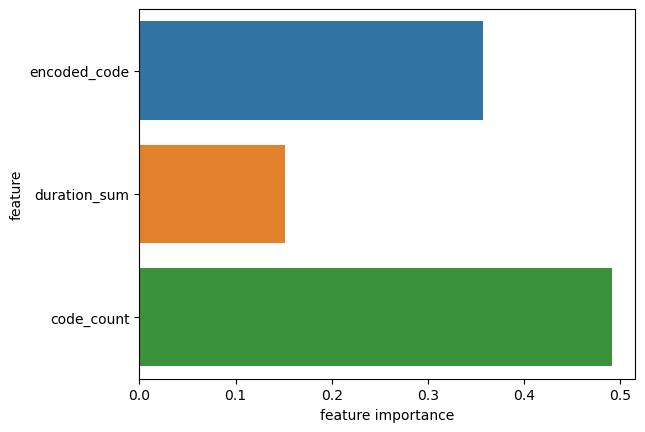

In [369]:
import seaborn as sns
%matplotlib inline

# feature importance 추출
print("Feature Importances:\n{0}\n".format(np.round(dt_clf.feature_importances_, 3)))

# feature 별 feature importance 매핑
for name, value in zip(['encoded_code', 'duration_sum', 'code_count'], dt_clf.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))
    
# feature importance 시각화
g = sns.barplot(x=dt_clf.feature_importances_, y=['encoded_code', 'duration_sum', 'code_count'])
g.set_xlabel('feature importance', size=10)
g.set_ylabel('feature', size=10)

In [352]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(dt_clf, out_file="tree_reduced3.dot", class_names = ['low', 'high'], 
                           feature_names = ['encoded_code', 'encoded_duration', 'code_count'], impurity=True, filled=True)

In [355]:
behavior.to_csv('./data/behavior_recuded_preprocessed.csv')